In [28]:
from dotenv import load_dotenv
load_dotenv()

True

In [29]:
from langchain_community.document_loaders import PDFMinerLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

# get url
pdf_url = "https://www.dhcd.virginia.gov/sites/default/files/DocX/building-codes-regulations/archive-codes/2021/2021-virginia-construction-code.pdf"

# load doc
doc = PDFMinerLoader(pdf_url).load()


In [30]:


# split text
splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=256, chunk_overlap=50)

# TODO: Add metadata of page number
doc_splits = splitter.split_documents(doc)

In [ ]:
from langchain_openai import OpenAIEmbeddings
from langchain.tools.retriever import create_retriever_tool

# store in vectorstore
vectorstore = Chroma.from_documents(
  documents=doc_splits,
  collection_name="construction-code-rag",
  embedding=OpenAIEmbeddings())

retriever = vectorstore.as_retriever(k=5, lambda_mult=0.3, )

retriever_tool = create_retriever_tool(
  retriever=retriever,
  name="virginia_fairfax_construction_code",
  description="Search and return information about Construction code in Virginia Fairfax County."
)

tools = [retriever_tool]


In [42]:
# models
from langchain_groq import ChatGroq
from langchain_ollama import ChatOllama

llm = ChatGroq(model="llama-3.2-90b-vision-preview")
# llm = ChatOllama(model="llama3.2")

llm_with_manual = llm.bind_tools(tools)



In [43]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

def rag_agent(state: MessagesState):
  
  sys_msg = """
    You are a construction code assistant supporting a contractor working in Fairfax, Virginia. Your task is to answer construction code questions with precise, verified information from the Fairfax construction code manual.

    For each response:

    Answer the query accurately based solely on information from the manual. If necessary, call the retriever multiple times to gather all relevant details.
    Provide a source reference by including a sentence or excerpt from the manual, prefaced with “Source:”.
    If the information is not available in the manual, respond that the information could not be found.
    Do not provide information beyond the manual or make assumptions. All responses must strictly adhere to the manual's content.

    Provide a source reference by including a sentence or excerpt from the manual that supports your answer. Begin this section with “Source:” for clarity.
    Ensure all responses are informative, direct, and include the referenced material to maintain accuracy.  
  """
  
  response = llm_with_manual.invoke([SystemMessage(content=sys_msg)] +  state['messages'])
  return {
    'messages': [response]
  }
  
  
builder = StateGraph(MessagesState)
builder.add_node(rag_agent)
builder.add_node(ToolNode(tools, name="manual_retriever"))

builder.add_edge(START, "rag_agent")
builder.add_conditional_edges("rag_agent", tools_condition, {"tools": "manual_retriever", END: END})
builder.add_edge("manual_retriever", "rag_agent")

agent = builder.compile()





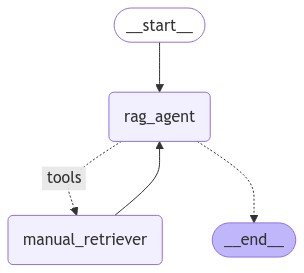

In [39]:
from IPython.display import display, Image

display(Image(agent.get_graph().draw_mermaid_png()))

In [44]:
msg = "I want to build an addition to my single house home, located in Vienna Virginia. The addition is going to be on the garageside, taking part of the garage and some part of the deck. What would be the steps to complete it, and what types of inspections do I need to pass. "
state = {
  "messages": [HumanMessage(content=msg)]
}

response = agent.invoke(state)

In [45]:
for m in response['messages']:
  m.pretty_print()

================================ Human Message =================================

I want to build an addition to my single house home, located in Vienna Virginia. The addition is going to be on the garageside, taking part of the garage and some part of the deck. What would be the steps to complete it, and what types of inspections do I need to pass. 
================================== Ai Message ==================================
Tool Calls:
  virginia_fairfax_construction_code (call_my8e)
 Call ID: call_my8e
  Args:
    query: Residential addition construction steps and required inspections in Fairfax County
  virginia_fairfax_construction_code (call_vvtg)
 Call ID: call_vvtg
  Args:
    query: Permitting requirements for residential addition in Fairfax County
  virginia_fairfax_construction_code (call_5k5f)
 Call ID: call_5k5f
  Args:
    query: Inspection checklist for residential addition in Fairfax County
================================= Tool Message =============================